# Data Science

## Linear Models

Consider a shopping trip where you buy apples and bananas. Let's say you have the following data:

| Date  | Apples | Bananas | Total Cost |
|-------|--------|---------|------------|
| 01/01 | 1      | 1       | £5         |
| 02/01 | 2      | 1       | £8         |


We want to find the price of each fruit. This is a linear model problem where we have a set of features (apples and bananas) and a target (total cost).

$\hat{y}(w,x) =w_0 +w_1x_1 + ... +w_px_p$

## From words to equations

A linear model predicts a target by combining feature columns:
$\hat{y} = w_0 + w_1 x_1 + \dots + w_p x_p$.

In matrix form for n rows and p features:
$X \in \mathbb{R}^{n \times p}$, $w \in \mathbb{R}^p$, $y \in \mathbb{R}^n$, and $\hat{y} = X w$ (without intercept) or $\hat{y} = X w + b$ with an intercept term.

Using the shopping example:
$X = \begin{bmatrix} 1 & 1 \\ 2 & 1 \end{bmatrix},\quad
w = \begin{bmatrix} p_{apple} \\ p_{banana} \end{bmatrix},\quad
y = \begin{bmatrix} 5 \\ 8 \end{bmatrix}$.

Solving gives $w = \begin{bmatrix} 3 \\ 2 \end{bmatrix}$ (apples £3, bananas £2).

Solvability depends on the columns of the design matrix $X$:
- If the feature columns are linearly independent, the least‑squares solution is unique.
- If some feature column is a linear combination of others (multicollinearity), $X^T X$ is singular and there are infinitely many solutions; scikit‑learn returns the minimum‑norm one via SVD.

Tip:
- Duplicate or perfectly correlated columns make $\operatorname{rank}(X) < p$ (number of features).
- Near‑collinearity keeps $\operatorname{rank}(X)=p$ but leads to a huge condition number and unstable coefficients.

In [1]:
import numpy as np
from statsmodels.api import OLS
import matplotlib.pyplot as plt

## NumPy basics

In [2]:
# 1. Handling Singular Matrices (Infinite Solutions)
# --------------------------------------------------
# CONFUSION CLARIFICATION: Rows vs Columns
# You might think singularity is about dependent ROWS (data points).
# However, in Linear Regression, we solve for weights using (X^T * X)^-1.
# If features (COLUMNS) are linearly dependent (Multicollinearity), 
# then X^T * X becomes Singular (non-invertible).
#
# Here we have two features that are identical (perfect multicollinearity).
# x1 = [1, 2], x2 = [1, 2].
# Target y = [2, 4].
# Any solution where w1 + w2 = 2 works.

singular_matrix = np.array([[1, 1, 2], [2, 2, 4]])
X_singular = singular_matrix[:, :2]
y_singular = singular_matrix[:, 2]
print(f"rank(X): {np.linalg.matrix_rank(X_singular)}")
print(f"rank(X^T X): {np.linalg.matrix_rank(X_singular.T @ X_singular)}")

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_singular, y_singular)

print("--- Perfect Singularity ---")
print(f"Intercept: {lr.intercept_}")
print(f"Coefficients: {lr.coef_}") 
# Sklearn returns [1, 1], which is the 'Minimum Norm' solution (1^2 + 1^2 = 2).
# Other solutions like [2, 0] have higher norm (2^2 + 0^2 = 4).


rank(X): 1
rank(X^T X): 1
--- Perfect Singularity ---
Intercept: 4.440892098500626e-16
Coefficients: [1. 1.]


### Why does random data "make it hard"?
In the **Perfect Singularity** case, the matrix $X^T X$ is strictly non-invertible. There are infinitely many ways to combine $x_1$ and $x_2$ to get $y$. `scikit-learn` detects this and explicitly chooses the **minimum-norm solution** (the shortest vector of weights).

In **Random Data**, features are almost never perfectly identical. Even a difference of $0.0001$ makes the matrix invertible. Now there is only **one unique solution** that fits the data exactly. Unfortunately, if there is even a tiny bit of noise, that unique solution usually involves massive coefficients that "fight" each other to fit that noise. 

OLS doesn't "choose" to have large coefficients; it is simply finding the only mathematical solution that exists. To get small coefficients back, we have to use **Regularization** (like Ridge).

### Breaking the Singularity
We can turn the "perfect" example into a "huge coefficient" example by adding just one datapoint that slightly breaks the pattern.

In [3]:
# Example A
# Adding a "noisy" 3rd datapoint to the singular example
# Point 1: [1, 1] -> 2
# Point 2: [2, 2] -> 4
# Point 3: [1, 1.001] -> 2.01 (Tiny difference in X, but relatively large change in y)

X_broken = np.array([[1, 1], [2, 2], [1, 1.001]])
y_broken = np.array([2, 4, 2.01])

lr_broken = LinearRegression().fit(X_broken, y_broken)

print("--- Broken Singularity (Huge Coefficients) ---")
print(f"Coefficients: {lr_broken.coef_}")
print(f"Norm: {np.linalg.norm(lr_broken.coef_):.2f}")


--- Broken Singularity (Huge Coefficients) ---
Coefficients: [-8. 10.]
Norm: 12.81


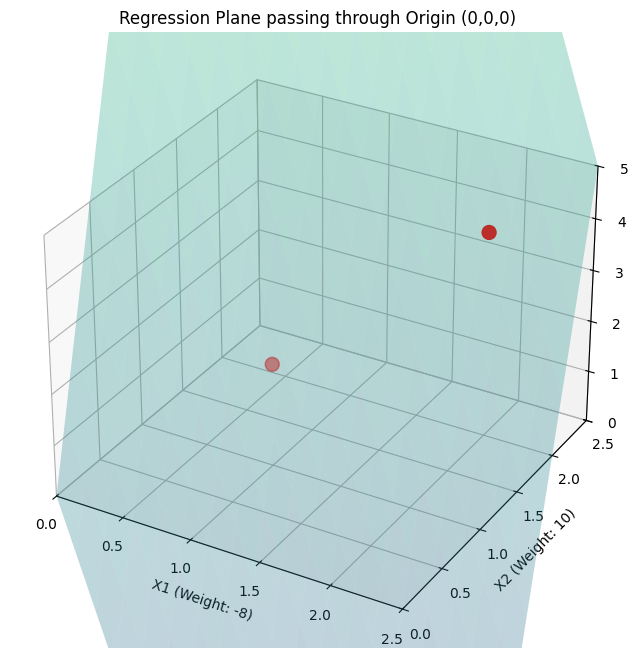

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Your original data points (no extra origin point added)
X = np.array([[1, 1], [2, 2], [1, 1.001]])
y = np.array([2, 4, 2.01])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 1. Scatter the data points
ax.scatter(X[:,0], X[:,1], y, color='red', s=100, label="Data Points")

# 2. Create the Regression Plane (w1=-8, w2=10, w0=0)
x_range = np.linspace(0, 2.5, 20)
X1, X2 = np.meshgrid(x_range, x_range)
Y_plane = -8*X1 + 10*X2

# 3. Plot the plane
ax.plot_surface(X1, X2, Y_plane, alpha=0.3, cmap='viridis')

# 4. FORCE THE AXES TO SHOW THE ORIGIN
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_zlim(0, 5)

# Labels
ax.set_xlabel('X1 (Weight: -8)')
ax.set_ylabel('X2 (Weight: 10)')
ax.set_zlabel('y')
ax.set_title('Regression Plane passing through Origin (0,0,0)')

plt.show()

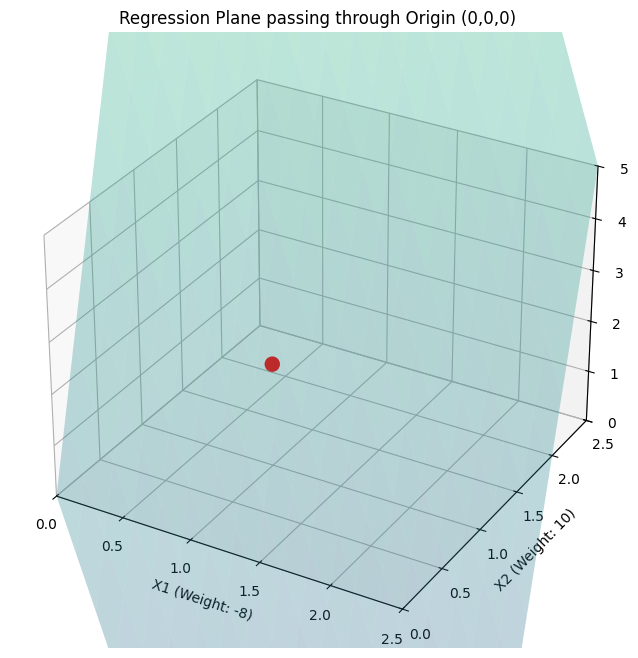

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Your original data points (no extra origin point added)
X = np.array([[1, 1], [1, 1.001]])
y = np.array([2, 2.01])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 1. Scatter the data points
ax.scatter(X[:,0], X[:,1], y, color='red', s=100, label="Data Points")

# 2. Create the Regression Plane (w1=-8, w2=10, w0=0)
x_range = np.linspace(0, 2.5, 20)
X1, X2 = np.meshgrid(x_range, x_range)
Y_plane = -8*X1 + 10*X2

# 3. Plot the plane
ax.plot_surface(X1, X2, Y_plane, alpha=0.3, cmap='viridis')

# 4. FORCE THE AXES TO SHOW THE ORIGIN
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_zlim(0, 5)

# Labels
ax.set_xlabel('X1 (Weight: -8)')
ax.set_ylabel('X2 (Weight: 10)')
ax.set_zlabel('y')
ax.set_title('Regression Plane passing through Origin (0,0,0)')

plt.show()

In [6]:
# Example B
# Point 1: [1, 1] -> 2
# Point 2: [1, 1.001] -> 2.01 (Tiny difference in X, but relatively large change in y)

X_broken = np.array([[1, 1], [1, 1.001]])
y_broken = np.array([2, 2.01])

lr_broken = LinearRegression().fit(X_broken, y_broken)

print("--- Broken Singularity (Huge Coefficients) ---")
print(f"Coefficients: {lr_broken.coef_}")
print(f"Norm: {np.linalg.norm(lr_broken.coef_):.2f}")
print(lr_broken.intercept_)

--- Broken Singularity (Huge Coefficients) ---
Coefficients: [ 0. 10.]
Norm: 10.00
-8.000000000000885


In [7]:
from sklearn.linear_model import LinearRegression

# Original data + 1 'Messy' Outlier
X_messy = np.array([[1, 1], [2, 2], [1, 1.000001], [1.5, 1.5]])
y_messy = np.array([2, 4, 2.01, 10]) # 10 is way too high!

model = LinearRegression().fit(X_messy, y_messy)

print(f"New Weights: {model.coef_}")
print(f"New Intercept: {model.intercept_}")
print(f"R^2 Score: {model.score(X_messy, y_messy):.4f}")

New Weights: [ 2323335.33364778 -2323333.33364778]
New Intercept: 2.3333333321474488
R^2 Score: 0.2394


In [8]:
from sklearn.linear_model import LinearRegression, Ridge
import numpy as np

# Your unstable data
X_unstable = np.array([[1, 1], [2, 2], [1, 1.000001], [1.5, 1.5]])
y_unstable = np.array([2, 4, 2.01, 10])

# 1. Standard Linear Regression (Exploding Weights)
ols = LinearRegression().fit(X_unstable, y_unstable)

# 2. Ridge Regression (Tamed Weights)
# alpha is the "strength" of the penalty.
ridge = Ridge(alpha=0.0001).fit(X_unstable, y_unstable)

print("--- OLS (Standard) ---")
print(f"Weights: {ols.coef_}")
print(f"Intercept: {ols.intercept_}")

print("\n--- Ridge (Regularized) ---")
print(f"Weights: {ridge.coef_}")
print(f"Intercept: {ridge.intercept_}")

--- OLS (Standard) ---
Weights: [ 2323335.33364778 -2323333.33364778]
Intercept: 2.3333333321474488

--- Ridge (Regularized) ---
Weights: [1.63985436 1.62718073]
Intercept: 0.010326343691385631


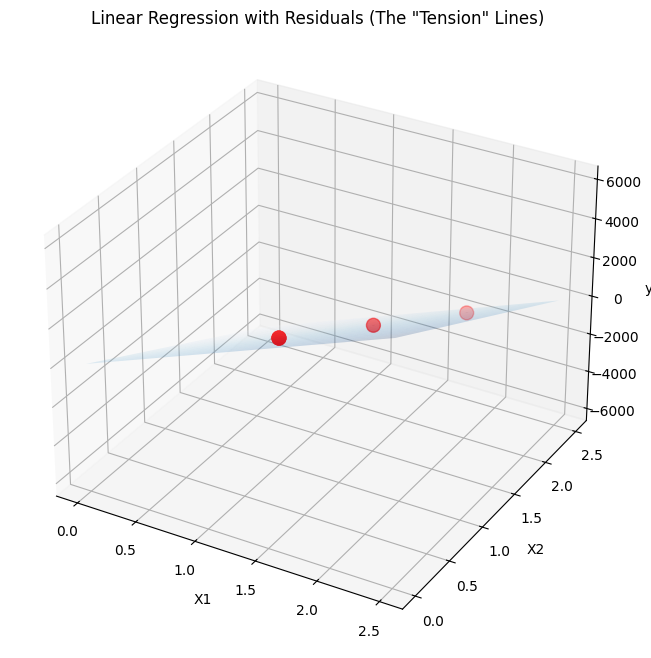

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. Data with an outlier
X = np.array([[1, 1], [2, 2], [1, 1.001], [1.5, 1.5]])
y = np.array([2, 4, 2.01, 10])

# 2. Fit the model
model = LinearRegression().fit(X, y)
w1, w2 = model.coef_
w0 = model.intercept_

# 3. Predict to find the 'anchor points' on the plane for error lines
y_pred = model.predict(X)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 4. Plot the plane
x_range = np.linspace(0, 2.5, 20)
X1, X2 = np.meshgrid(x_range, x_range)
Z = w1*X1 + w2*X2 + w0
ax.plot_surface(X1, X2, Z, alpha=0.2, cmap='Blues')

# 5. Plot the actual data points
ax.scatter(X[:,0], X[:,1], y, color='red', s=100, label="Actual Data")

# 6. DRAW RESIDUAL LINES (The "Tension")
for i in range(len(y)):
    # Line from the actual point (red dot) to the predicted point on the plane
    ax.plot([X[i,0], X[i,0]], [X[i,1], X[i,1]], [y[i], y_pred[i]],
            color='black', linestyle='--', linewidth=1.5)

ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('y')
ax.set_title('Linear Regression with Residuals (The "Tension" Lines)')
plt.show()

### Why are the coefficients different?

You might notice that **Example A** and **Example B** result in different coefficients, even though they share the same data points (1, 1) and (1, 1.001).

*   **In Example A**, we have 3 data points. With 2 features and 1 intercept, we have 3 unknowns. The point `(2, 2) -> 4` forces the intercept to be exactly `0` and determines a unique solution: $w = [-8, 10], b = 0$.
*   **In Example B**, we only have 2 data points. Since we are trying to solve for 3 parameters ($w_1, w_2,$ and intercept), the system is **underdetermined**—there are infinitely many combinations that fit perfectly.
*   **Sklearn's Choice**: When a system is underdetermined, `LinearRegression` (via SVD) picks the **minimum-norm solution** for the weights after centering the data. In Example B, $x_1$ is constant ($1$), so after centering it becomes $0$. To keep the weight vector as short as possible, `sklearn` sets $w_1 = 0$ and lets the intercept handle the constant offset.

Both solutions are "correct" for the data they were given, but Example B has a redundancy (perfect multicollinearity between $x_1$ and the intercept) that `sklearn` resolves by zeroing out the redundant weight.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

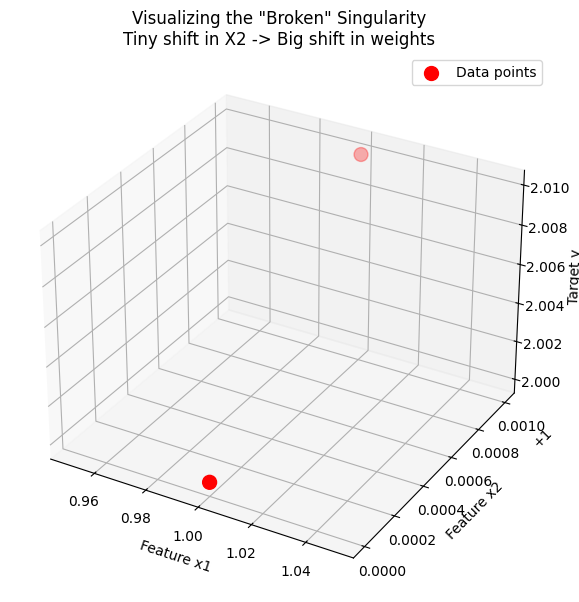

In [11]:
# Visualizing the broken singularity
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_broken[:, 0], X_broken[:, 1], y_broken, c='red', s=100, label='Data points')

# Annotate points to show the tiny change
ax.text(1, 1, 2.1, " (1, 1) -> 2", color='black')
ax.text(2, 2, 4.1, " (2, 2) -> 4", color='black')
ax.text(1, 1.001, 1.9, " (1, 1.001) -> 2.01", color='blue')

ax.set_xlabel('Feature x1')
ax.set_ylabel('Feature x2')
ax.set_zlabel('Target y')
ax.set_title('Visualizing the "Broken" Singularity\nTiny shift in X2 -> Big shift in weights')
plt.legend()
plt.show()

In [12]:
# 2. Real World Issue: Near-Singularity (Instability)
# ---------------------------------------------------
# In real datasets, you rarely get perfect singularity. 
# instead you get "Multicollinearity" (features highly correlated).
# This causes the matrix to be nearly singular, leading to unstable coefficients.

np.random.seed(42)
n = 100
x1 = np.random.rand(n)
x2 = x1 + 0.001 * np.random.rand(n) # x2 is almost identical to x1
y = x1 + x2 + 0.1 * np.random.randn(n) # y is roughly x1 + x2

X_near = np.column_stack((x1, x2))

# Standard Linear Regression
lr_unstable = LinearRegression().fit(X_near, y)

print("\n--- Near Singularity (Multicollinearity) ---")
print(f"cond(X): {np.linalg.cond(X_near):.2e}")
print(f"Intercept: {lr_unstable.intercept_}")
print(f"Linear Regression Coefficients: {lr_unstable.coef_}")
# Notice the coefficients are large and opposite (e.g. -70, +72) to sum to 2.
# This makes the model very sensitive to noise.



--- Near Singularity (Multicollinearity) ---
cond(X): 2.78e+03
Intercept: -0.008938996355011275
Linear Regression Coefficients: [-70.96531354  72.93114101]


In [13]:
# 3. The Fix: Regularization (Ridge)
# ----------------------------------
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1).fit(X_near, y)

print(f"Ridge Intercept: {ridge.intercept_}")
print(f"Ridge Regression Coefficients:  {ridge.coef_}")
# Ridge forces the coefficients to be small and stable (e.g. 0.97, 0.98).

Ridge Intercept: 0.03323751675747055
Ridge Regression Coefficients:  [0.97311397 0.97919412]


## 4. Does it matter for Gradient Descent?

The examples above use the **analytical solution** (Matrix Inversion/SVD). What if we use an iterative algorithm like **Gradient Descent**?

### The "Loss Valley"
When features are highly correlated, the loss function $J(w)$ doesn't have a single sharp minimum point. Instead, it has a **long, flat valley** (or trough).
- Any combination of weights along the bottom of this valley results in nearly the same error.
- Gradient descent will quickly drop into the valley, but once inside, the gradient becomes tiny.
- The algorithm might "stop" anywhere along the valley depending on the **learning rate**, **initialization**, or **noise**.

### Example: Sensitivity to Initialization
In the code below, we use two identical features. We run a simple Gradient Descent twice, starting from different initial weights.

In [14]:
# 4. Gradient Descent Sensitivity
# ------------------------------
# We'll use the same nearly-singular data from before
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_near_scaled = scaler.fit_transform(X_near)

def manual_gd(X, y, lr=0.01, steps=1000, init_w=None):
    w = init_w if init_w is not None else np.zeros(X.shape[1])
    for _ in range(steps):
        # Gradient of MSE: (2/n) * X^T * (Xw - y)
        grad = 2/len(y) * X.T @ (X @ w - y)
        w -= lr * grad
    return w

w_start_a = np.array([10.0, 0.0])
w_start_b = np.array([0.0, 10.0])

w_final_a = manual_gd(X_near_scaled, y, init_w=w_start_a)
w_final_b = manual_gd(X_near_scaled, y, init_w=w_start_b)

print("--- Gradient Descent on Near-Singular Data ---")
print(f"Initial weights A: {w_start_a} -> Final: {w_final_a}")
print(f"Initial weights B: {w_start_b} -> Final: {w_final_b}")
# Both solutions are "correct" (they minimize loss), but they are totally different!


--- Gradient Descent on Near-Singular Data ---
Initial weights A: [ 5.29032902 -4.70916098] -> Final: [ 5.29032902 -4.70916098]
Initial weights B: [-4.709574    5.29074205] -> Final: [-4.709574    5.29074205]


### Summary: Should you be aware of this?

**Yes.** While `sklearn` uses SVD to return a valid minimum‑norm solution instead of crashing, singular or nearly singular design matrices signal feature redundancy you should address.

1.  **Perfect Singularity (feature dependency):** Columns are linearly dependent, so $X^T X$ is singular. The solution is not unique; scikit‑learn picks the minimum‑norm one using SVD.
2.  **Near Singularity (multicollinearity):** Columns are highly correlated but not identical. The solution is **unique**, but extremely unstable. Small noise in $y$ causes the coefficients to explode to fit the data perfectly.
3.  **Gradient Descent:** Multicollinearity creates a "loss valley." The optimization becomes slow and the specific weights chosen become arbitrary (dependent on initialization), making them impossible to interpret.

How to notice it quickly:
- `np.linalg.matrix_rank(X) < n_features` (singular).
- Very large condition number: `np.linalg.cond(X)` or `np.linalg.cond(X.T @ X)` (near‑singular).
- Unstable coefficients across resamples or after small data perturbations.

What to do:
- Prefer **Ridge** (L2) or **Lasso** (L1) to stabilize/perform feature selection.
- Remove/merge redundant features, or use **PCA** to decorrelate.
- Standardize features before regularization.
